In [1]:
import pandas as pd
import numpy as np
import librosa
import IPython.display as ipd
from librosa.display import specshow
import matplotlib.pyplot as plt
import tqdm

### Chargement des données dans un dataframe, et application d'un log aux valeurs d'abondances.

In [2]:
data = pd.read_csv("data/data HS.csv")
data = data.apply(pd.to_numeric)
data.index = range(len(data.index))
data = data.sort_values(by=['Temps (min)'])
data.loc[:,'2905.mzML':] = data.loc[:,'2905.mzML':].applymap(np.log)

In [3]:
pd.set_option('display.max_columns', 15)
data.describe()

,Masse (mz),Temps (min),2905.mzML,2915.mzML,2910.mzML,2908.mzML,2907.mzML,...,3069.mzML,3070.mzML,3064.mzML,3071.mzML,3072.mzML,3073.mzML,Unnamed: 171
count,953.000000,953.000000,257.000000,597.000000,938.000000,942.000000,941.000000,...,789.000000,754.000000,821.000000,801.000000,813.000000,937.000000,0.0
mean,401.237266,12.775593,11.926353,12.317468,13.998088,13.967346,13.958635,...,12.620999,12.968401,13.423927,13.207887,13.055290,13.844849,NaN
std,182.765170,9.082042,3.511650,2.762897,1.831448,1.897797,1.894486,...,2.570495,2.681348,2.513927,2.661562,2.722833,1.840990,NaN
min,100.076200,0.070000,7.050952,7.369868,7.554560,7.029021,7.407205,...,6.657372,6.438135,6.437472,6.816665,6.403856,6.521257,NaN
25%,251.090900,3.450000,8.777498,10.030649,12.992711,12.971277,12.951902,...,10.856337,11.160825,11.966013,11.401371,11.329269,12.812267,NaN
50%,385.221100,12.790000,11.137672,12.355275,14.028820,14.017943,14.004657,...,12.772904,13.489097,13.837531,13.518024,13.470308,13.887349,NaN
75%,529.268100,17.630000,14.951587,14.374544,15.034141,15.048209,15.018363,...,14.526844,14.888700,15.196967,15.128743,15.071262,14.949742,NaN
max,799.563300,33.730000,21.043190,21.701000,20.658458,21.502158,20.729492,...,21.043648,20.481150,21.070608,21.109835,20.430192,20.961053,NaN


### Fonctions de sonification
La première est la version initiale et commentée, la 2e donne les mêmes résultats, mais utilise pleinement les fonctionnalités de numpy et est donc beaucoup plus rapide.

In [4]:
# Structure d'entrée attendue : vecteur taille m et matrice taille n*m avec : 
# n = durée_expérience / résolution_temporelle = nombre de relevés pendant l'expérience
# m = nombre de molécules distinctes ("Masse (mz)" distincte)

def son(mass_vector, abundance_matrix, sr=22050, duration=35):
    try:
        assert(len(mass_vector) == len(abundance_matrix[0]))
    except:
        raise(Exception("Pas la bonne taille de données"))
    
    n = len(abundance_matrix)
    m = len(mass_vector)
    durationOfOneSample = duration*sr/n
    
    amplitude_matrix = abundance_matrix / np.max(abundance_matrix) # On ramène l'amplitude dans ]0,1]
    
    sounds = np.zeros((duration*sr,m)) # Chaque colonne est une molécule différente, chaque ligne est une unité temporelle
    
    for i in tqdm.tqdm(range(duration*sr)): # Parcours par temps croissant (on suppose la matrice d'abondance triée)
        sampleNumber = int(i/durationOfOneSample) # Pour le padding. On pourrait remplacer ça par une interpolation
        t = i/sr # temps
        
        for j in range(m): # Parcours de toutes les molécules pour un instant donné
            freq = mass_vector[j] # fréquence
            amp = abundance_matrix[sampleNumber][j] # amplitude
            sounds[i][j] = amp * np.sin(2*np.pi*freq*t)
    
    return np.mean(sounds,axis=1) # Fusion des channels de toutes les molécules

In [24]:
def son_optimise(mass_vector, abundance_matrix, sr=22050, duration=35):
    try:
        assert(len(mass_vector) == len(abundance_matrix[0]))
    except:
        raise(Exception("Pas la bonne taille de données"))
    
    durationOfOneSample = duration*sr/len(abundance_matrix)
    
    time_vector = np.arange(0,duration*sr,1) / sr
    
    time_vector = time_vector.reshape((len(time_vector),1))
    mass_vector = np.transpose(mass_vector.reshape((len(mass_vector),1)))
    amplitude_matrix = np.array([abundance_matrix[int(i/durationOfOneSample)] for i in range(duration*sr)])

    sounds = np.multiply(amplitude_matrix, np.sin(2 * np.pi * np.matmul(time_vector, mass_vector)))
    
    audio = np.mean(sounds,axis=1)
    
    return audio / np.max(audio)

### Test avec sur les données actuelles
Pour l'instant je n'ai pas les données dont j'ai besoin, je n'ai que les données des pics pour chaque molécule. 
Mais en attendant, on peut imaginer que la distribution dans le temps de toutes les molécules est une gaussienne.

In [45]:
def generate_test_abundance_matrix(df, column):
    sigma = 1/np.sqrt(2*np.pi) # variance de la gaussienne, ici choisi pour que le max de la gaussienne soit 1
    amp = 1/np.sqrt(2*np.pi*sigma**2) # terme multiplicatif de la gaussienne
    
    spike_height = df[column].loc[df[column] > 0].to_numpy() # amplitude des pics
    spike_time = df["Temps (min)"].loc[df[column] > 0].to_numpy() # position temporelle des pics
    
    n = int(35/0.07)   # nombre de relevés pendant l'expérience
    m = len(spike_height) # nombre de molécules PRESENTES DANS L'ECHANTILLON différentes
    abundance_matrix = np.zeros((n,m))
    
    for i in range(n):
        t = i*0.07
        for j in range(m):
            if not np.isnan(spike_height[j]):
                abundance_matrix[i][j] = amp * spike_height[j] * np.exp(-(t-spike_time[j])**2 / (2*sigma**2))
    
    return abundance_matrix

Le graphe ce-dessous représente les différentes colonnes de la matrice d'abondance. Chaque courbe représente l'abondance  d'une molécule au niveau du détecteur en fonction du temps. Ces courbes vont venir moduler en amplitude le signal de la molécule correspondante.

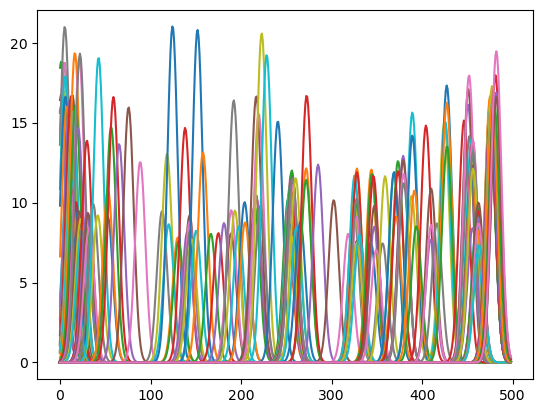

In [46]:
am = generate_test_abundance_matrix(data,"2905.mzML")
plt.plot(am);

Si au lieu de représenter toutes les courbes individuellement on choisit de représenter la moyenne de ces dernières, on obtient l'enveloppe suivante. On constatera plus loin que cette enveloppe correspond à l'enveloppe du signal final.

Text(0.5, 1.0, "Moyenne des colonnes de la matrice d'abondance")

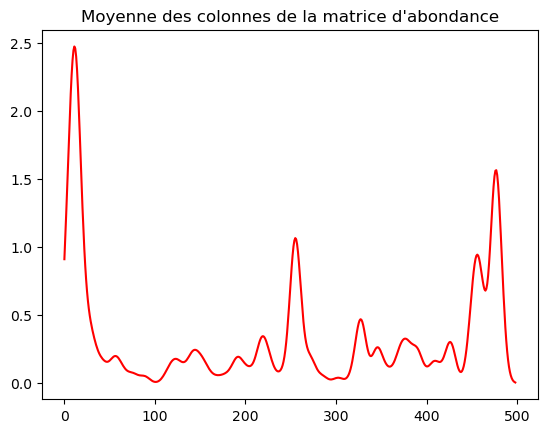

In [47]:
plt.plot(np.mean(am,axis=1),color='red');
plt.title("Moyenne des colonnes de la matrice d'abondance")

### Génération audio

In [52]:
# Paramètres

sr = 11000 # sampling rate (fréquence d'échantillonage)
duration = 10
mass_vector = data["Masse (mz)"].loc[data["2905.mzML"] > 0].to_numpy()
abundance_matrix = am

In [53]:
%%time
# Génération avec la 1re fonction (c'est long)

audio = son(mass_vector, abundance_matrix, sr, duration)
display(ipd.Audio(audio, rate=sr))

100%|█████████████████████████████████████████████████████████████████████████| 110000/110000 [00:52<00:00, 2092.40it/s]


CPU times: user 53 s, sys: 0 ns, total: 53 s
Wall time: 52.6 s


In [54]:
%%time
# Génération avec la 2e fonction

audio = son_optimise(mass_vector, abundance_matrix, sr, duration)
display(ipd.Audio(audio, rate=sr))

CPU times: user 887 ms, sys: 38.3 ms, total: 925 ms
Wall time: 922 ms


### Analyse du son généré

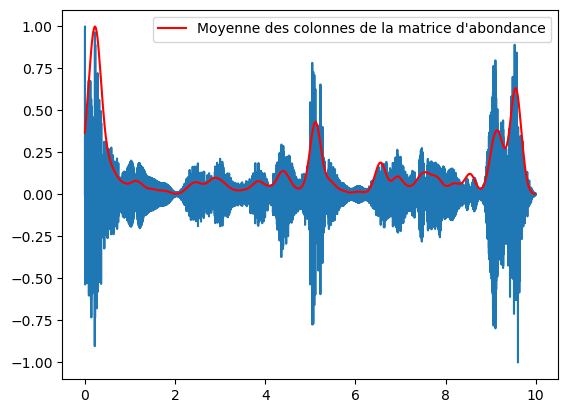

In [57]:
plt.plot(np.arange(0,duration,1/sr),audio);
plt.plot(np.arange(0,duration,duration/len(am)),np.mean(am,axis=1)/np.max(np.mean(am,axis=1)),color='red',label="Moyenne des colonnes de la matrice d'abondance")
plt.legend();

### Comparaison entre le spectrogramme et le graphe représentant la position des pics d'abondance

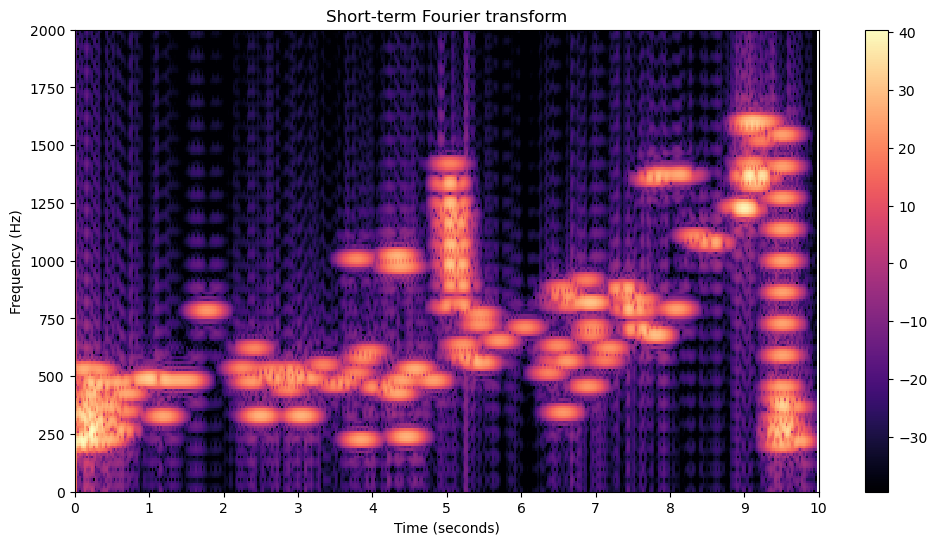

In [58]:
# Affichage du spectrogramme

plt.figure(figsize=(12, 6))

y_stft = librosa.stft(np.array(audio), win_length=1024)
y_spectrogram = librosa.amplitude_to_db(np.abs(y_stft))
specshow(y_spectrogram, cmap="magma", x_axis="time", y_axis="hz")
plt.title("Short-term Fourier transform")
plt.colorbar()
plt.xlabel("Time (seconds)")
plt.xlim(0, duration)
plt.ylabel("Frequency (Hz)")
plt.ylim(0, 2000);

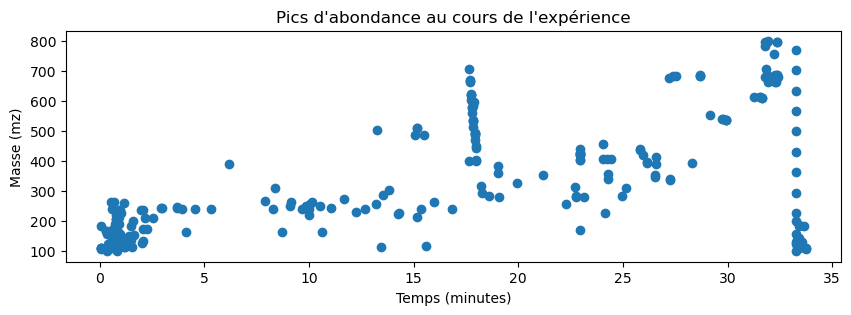

In [61]:
plt.figure(figsize=(10,3))
plt.scatter(data["Temps (min)"].loc[data["2905.mzML"] > 0],data["Masse (mz)"].loc[data["2905.mzML"] > 0])
plt.xlabel("Temps (minutes)")
plt.ylabel("Masse (mz)")
plt.title("Pics d'abondance au cours de l'expérience");